# OSMnx features demo

Get street networks anywhere in the world from OpenStreetMap data then analyze and visualize them.

More info:

  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [27]:
import networkx as nx
import numpy as np
import geopandas as gpd
import fiona
import osmnx as ox
import requests
import skmob
import pandas as pd
import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

warnings.filterwarnings(action='once')
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.1'

C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


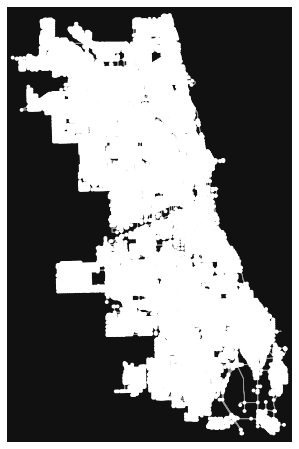

In [2]:
# get the walking network for piedmont
place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G)

In [3]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


755005175.7457961

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

## Visualize street centrality

In [4]:
# assign speeds and traversal times to the edges
for u, v, k, d in G.edges(keys=True, data=True):
    if 'residential' in d['highway']:
        d['speed'] = 20
    elif 'tertiary' in d['highway']:
        d['speed'] = 30
    elif 'secondary' in d['highway']:
        d['speed'] = 40
    else:
        d['speed'] = 25
    
    # calculate time to traverse edge, in minutes
    d['time'] = d['length'] / (d['speed'] * 1609.34 / 60) #miles/hour to meters/minute

## Importing Crime Data (To be used later)....  for simulating an average crime scenario... Best case, Worst case and Average Crime Rate Data Statistic

In [5]:
data = pd.read_csv('chicago_crime_median_timestamp.csv')#, sep = " ", names = ['time', 'lon', 'lat'])
data['user_id']=1

In [6]:
data

,Timestamp,Latitude,Longitude,#Responders,Police,Priority,Service Time,user_id
0,2014-10-28 0:00:00,41.756902,-87.650269,1,0,2,0 days 00:20:00,1
1,2014-10-28 0:00:00,41.871560,-87.703393,1,0,3,0 days 00:24:00,1
2,2014-10-28 0:00:00,41.742710,-87.634088,1,0,3,0 days 00:34:00,1
3,2014-10-28 0:01:00,41.904385,-87.732190,1,0,3,0 days 00:24:00,1
4,2014-10-28 0:01:00,41.891769,-87.622137,1,0,3,0 days 00:25:00,1
...,...,...,...,...,...,...,...,...
745,2014-10-28 23:45:00,41.760329,-87.574934,1,0,3,0 days 00:30:00,1
746,2014-10-28 23:45:00,41.809297,-87.687864,1,0,3,0 days 00:37:00,1
747,2014-10-28 23:47:00,41.764249,-87.651669,1,0,2,0 days 00:28:00,1
748,2014-10-28 23:50:00,41.801719,-87.630704,1,0,3,0 days 00:23:00,1


In [7]:
crime_data = data[[ 'Timestamp','Latitude', 'Longitude','Priority','Service Time']] 
crime_data.head()

C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,Latitude,Longitude,Priority,Service Time
0,2014-10-28 0:00:00,41.756902,-87.650269,2,0 days 00:20:00
1,2014-10-28 0:00:00,41.871560,-87.703393,3,0 days 00:24:00
2,2014-10-28 0:00:00,41.742710,-87.634088,3,0 days 00:34:00
3,2014-10-28 0:01:00,41.904385,-87.732190,3,0 days 00:24:00
4,2014-10-28 0:01:00,41.891769,-87.622137,3,0 days 00:25:00


## Importing Police Location Data (Using that as location for police for basic simulation)

In [8]:
PS_data = pd.read_csv('Police_Stations_-_Map.csv')#, sep = " ", names = ['time', 'lon', 'lat'])
PS_data['user_id']=1

cr_lat=[]
cr_long=[]

for i in range(len(PS_data)):
    s = PS_data['LOCATION'][i]
    s= s[1:-1]
    f = [float(x) for x in s.split(", ")]
    cr_lat.append(f[0])
    cr_long.append(f[1])

PS_data['lat']=cr_lat
PS_data['long']=cr_long


C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
Gs = ox.utils_graph.get_largest_component(G, strongly=True)


In [10]:
PC_node=[]

for i in range(len(PS_data)):
    t = (ox.get_nearest_node(Gs, (cr_lat[i], cr_long[i])))
    PC_node.append(t)


In [11]:
class ndk:
    G=[]
    nodes=[]
    SPL={}
    def calc():
        for i in ndk.nodes:
            ndk.SPL[i]=nx.shortest_path_length(ndk.G, source=i, weight='time')
    def shortest_path_length(G, source, target, weight='none'):
        return ndk.SPL[source][target]
ndk.G=Gs
ndk.nodes=PC_node
ndk.calc()

In [12]:
def Cloning(li1): 
    li_copy = li1[:] 
    return li_copy

In [13]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [14]:
class Police:
    def __init__(self,ID,G,loc,resp,dt):
        self.ID=ID #a unique id
        self.G=G #pointer to the graph the officer travels on (Warning:edits to this graph have global consequences)
        self.loc=loc #the Node that the police officer is at
        self.resp=resp #true if the officer is responding to a crime event, false if patroling
        self.downtime=dt #Remaining time that the police is "down" due to a response event
        self.nodeInd=self.getNodeInd() #the index of the node that the officer is located in list(G.nodes())
    
    #tested
    #Randomly move the officer to an adjacent node if they are not responding
    def walk(self):
        if not(self.resp):
            wk= list(nx.classes.function.all_neighbors(self.G,(list(self.G.nodes)[self.nodeInd])))
            j = np.random.choice(wk)
            self.updateLoc(j)
            
    #moves the police officer toward the node they need to respond to
    def respond(self):
        if self.resp:
            return
    
    #updates the police location (no matter if they are responding or patroling)
    def update(self):
        i.walk()
        i.respond()
        
    #updates the location of the officer to the new Node (and changes the node ID)
    def updateLoc(self,newloc):
        self.loc=newloc
        self.nodeInd=self.getNodeInd()
        
    #gets the index of the node that corresponds to its ID
    def getNodeInd(self):
        return list(self.G.nodes).index(self.loc)

In [15]:
#initialize police officers as a list of variable from the class "Police"
NumberOfPolice=10
#Pol_loc=np.random.choice(len(G.nodes),size=(1,10),replace=False)
Police_officers=[]
for i in range(len(PC_node)):
    Pol_loc=PC_node[i]
    Police_officers.append(Police(i,G,Pol_loc,False,0))


## Evaluating Response time based on the nearest police location to the crime

## Initialize varibales : no of police associated with police location, no of police needed based on crime, 

In [16]:
crime_node=[]

Crime_geo =[]

for i in range(len(crime_data)):
    t = (ox.get_nearest_node(Gs, (crime_data['Latitude'][i], crime_data['Longitude'][i])))
    x = Point(crime_data['Longitude'][i],crime_data['Latitude'][i])
    Crime_geo.append(x)    
    crime_node.append(t)

In [17]:
from datetime import datetime
datetime_object=[]
VG_datetime_object=[]
NVG_datetime_object=[]
#t0 = '2014-08-01 00:00:00'  # worst case day
t0 = '2014-10-28 00:00:00'  # median case day
t_ini = datetime.strptime(t0, '%Y-%m-%d %H:%M:%S')
time_seq=[]
VG_time_seq=[]
NVG_time_seq=[]

srvtime_object=[]
ser_time =[]
s0 ='00:00:00'
ss_ini = datetime.strptime(s0, '%H:%M:%S')

for i in range(len(crime_data)):
    datetime_str = crime_data['Timestamp'][i]
    datetime_object.append(datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S'))
    tt = (datetime_object[i]-t_ini).total_seconds()
    time_seq.append(tt)
    
    srvtime_str = crime_data['Service Time'][i]
    srvtime_object.append(datetime.strptime(srvtime_str[7:-1],'%H:%M:%S'))
    ss = (srvtime_object[i]-ss_ini).total_seconds()
    ser_time.append(ss)
 

In [18]:
time_min = [x / 60 for x in time_seq]
ser_min = [x / 60 for x in ser_time]
Crime = [time_min,crime_node,ser_min,Crime_geo]

In [19]:
police = PC_node
NoOfPolice = 2;    #### Change no of police here


## Police Beats

In [20]:

multipol = fiona.open("Chicago_PB.shp")
multi= multipol.next()

C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:2: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  


In [21]:
fp = "Chicago_PB.shp"
polys  = gpd.read_file(fp)

In [22]:
polys['dist_num'][2] = 16
polys['dist_num'][3] = 16
polys['dist_num'][7] = 22

C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
southern = polys[polys['dist_num']=='7']
poly = southern['geometry']

In [24]:
geometry =[Point (xy) for xy in zip(PS_data['long'],PS_data['lat'])]

In [25]:
geo_df = gpd.GeoDataFrame(PS_data,geometry = geometry)

C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

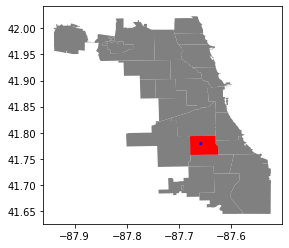

In [28]:
fig, ax = plt.subplots()

polys.plot(ax=ax, facecolor='gray');
southern.plot(ax=ax, facecolor='red');
geo_df[geo_df['DISTRICT'] == '7'].plot(ax=ax, color='blue', markersize=5)


In [29]:
import warnings
warnings.filterwarnings("ignore")

C:\Users\chitr\anaconda3\envs\skmob\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
### Police dispatch logic according to jurisdiction

def dipatch_logic(polys, pt):
    
    ## for loop to check that the point lies in which polygon 
    for x in range(len(polys)):
        if pt.within(polys['geometry'][x]):
            dis_t= polys['dist_num'][x]
            
            break
            
                        
    ## if the point is outside the polygons and the point is approximated to the closest polygon
    dis_t =0; ## variable to check if the point lied within the boundary       
    if dis_t==0:
        dd = 1000000;
        for x in range(len(polys)): 
            t1  = polys['geometry'][x]
            t = gpd.GeoSeries(t1)
            t.crs = 4326

            t2 = gpd.GeoSeries([pt])
            t2.crs = 4326

            dist = t.distance(t2)
            
            if (dist <= dd).bool():
                dd = dist
                dis_t = polys['dist_num'][x]              
            
    return dis_t   

In [31]:
def eva_resp_time(police,Crime,NoOfOfficer,polys,Gs):
    Resp_time = []
    orig_node = police
    #ser_time = 1200 # 20 mins service time
    my_array=[]
    arr_crime = [[0 for i in range(2)] for j in range(len(orig_node))]
    my_array = np.array(arr_crime).astype('int64')
    my_array[:,1]= orig_node 
    PC_stalk = [[0 for i in range(9)] for j in range(len(orig_node))] 
    for x in range(len(orig_node)):
        PC_stalk[x][0] =orig_node[x]
    for x in range(len(orig_node)):
        for y in range(3,9):
            PC_stalk[x][y]=[]
    columnIndex = 0   
    for j in range(len(Crime[0])):
        dest_node = Crime[1][j]
        Crime_node = Crime[1][j]
        Crime_time = Crime[0][j] ##chnage this
        Ser_time = Crime[2][j]
        if j !=len(Crime[0])-1:
            Crime_time_next = Crime[0][j+1]  ##change this 


        ### Change dispatch logic here

        pt = Crime[3][j]
        x= dipatch_logic(polys, pt)

        if not isinstance(x, str):
            x = str(x)

        te = PS_data[PS_data['DISTRICT'] == x]        
        trr = (ox.get_nearest_node(Gs, (te['lat'].values[0], te['long'].values[0])))        

        s = trr
        idx = np.argwhere(column(PC_stalk, 0) == s)[0][0]

        if PC_stalk[idx][1] < NoOfOfficer:  # 
                PC_stalk[idx][1]= PC_stalk[idx][1]+1
                PC_stalk[idx][3].append(Crime_time)
                PC_stalk[idx][4].append(Crime_node)
                temp = ndk.shortest_path_length(Gs, PC_stalk[idx][0], Crime_node, weight='time')
                PC_stalk[idx][5].append(2*temp + Crime_time + Ser_time)
                Resp_time.append([temp,Crime_time])

        else : #--> 

            PC_stalk[idx][2]= PC_stalk[idx][2]+1
            PC_stalk[idx][6].append(Crime_node)
            PC_stalk[idx][7].append(Crime_time)
            PC_stalk[idx][8].append(Ser_time)


        if j !=len(Crime[0])-1:
            ## Check if a PC node is going to available
            for idx in range(len(orig_node)):
                y=0
                while (PC_stalk[idx][1])>0 and y<=PC_stalk[idx][1]-1:
                    if PC_stalk[idx][5][y] <= Crime_time_next:
                        if PC_stalk[idx][2]>0:
                            PC_stalk[idx][2]= PC_stalk[idx][2]-1
                            temp1 = PC_stalk[idx][5][y]
                            PC_stalk[idx][3].remove(PC_stalk[idx][3][y])
                            PC_stalk[idx][3].append(temp1)
                            temp2 = PC_stalk[idx][6][0]     ##Change from y to 0
                            PC_stalk[idx][4].remove(PC_stalk[idx][4][y])
                            PC_stalk[idx][4].append(temp2)
                            temp3 = ndk.shortest_path_length(Gs, PC_stalk[idx][0],temp2, weight='time')
                            wait = temp1 - PC_stalk[idx][7][0]
                            se_time = PC_stalk[idx][8][0]
                            PC_stalk[idx][5].remove(PC_stalk[idx][5][y])
                            PC_stalk[idx][5].append(2*temp3 + temp1 + se_time)
                            Resp_time.append([wait+temp3,PC_stalk[idx][7][0]])
                            PC_stalk[idx][6].remove(PC_stalk[idx][6][0])
                            PC_stalk[idx][7].remove(PC_stalk[idx][7][0])
                            PC_stalk[idx][8].remove(PC_stalk[idx][8][0])
                        else:
                            PC_stalk[idx][1]= PC_stalk[idx][1]-1
                            PC_stalk[idx][3].remove(PC_stalk[idx][3][y])
                            PC_stalk[idx][4].remove(PC_stalk[idx][4][y])
                            PC_stalk[idx][5].remove(PC_stalk[idx][5][y])
                    else:
                        y=y+1
    d=[]
    for idx in range(len(orig_node)):
        while PC_stalk[idx][2]>0:
            a = min(PC_stalk[idx][5])
            ind = PC_stalk[idx][5].index(a)
            PC_stalk[idx][2]= PC_stalk[idx][2]-1
            temp1 = PC_stalk[idx][5][ind]
            PC_stalk[idx][3].remove(PC_stalk[idx][3][ind])
            PC_stalk[idx][3].append(temp1)
            temp2 = PC_stalk[idx][6][0]
            PC_stalk[idx][4].remove(PC_stalk[idx][4][ind])
            PC_stalk[idx][4].append(temp2)
            temp3 = ndk.shortest_path_length(Gs, PC_stalk[idx][0],temp2, weight='time')
            wait = temp1 - PC_stalk[idx][7][0]
            ser_time = PC_stalk[idx][8][0]
            PC_stalk[idx][5].remove(PC_stalk[idx][5][ind])
            PC_stalk[idx][5].append(2*temp3 + temp1 + ser_time)
            d.append([wait+temp3,PC_stalk[idx][7][0]])
            PC_stalk[idx][6].remove(PC_stalk[idx][6][0])
            PC_stalk[idx][7].remove(PC_stalk[idx][7][0])
            PC_stalk[idx][8].remove(PC_stalk[idx][8][0])
    Resp_time.extend(d)
    return Resp_time

In [32]:
Resp_time = eva_resp_time(police,Crime,NoOfPolice,polys,Gs)

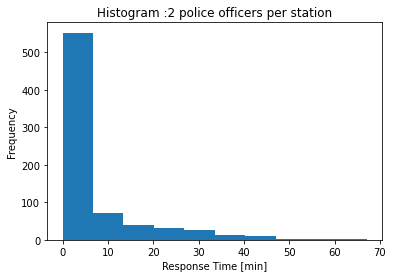

In [33]:
import matplotlib.pyplot as plt

res_time = column(Resp_time, 0)

plt.hist(res_time)
plt.ylabel('Frequency')
plt.xlabel('Response Time [min]')
plt.title("Histogram :" + str(NoOfPolice) + " police officers per station");
 
plt.show()


In [34]:
import statistics

print('The median with ' + str(NoOfPolice) + ' officers per station is ', statistics.median(res_time))
avg1 = sum(res_time)/len(res_time)
print('The average with ' + str(NoOfPolice) + ' officers per station is ', round(avg1,2))
print('The max response time with ' + str(NoOfPolice) + ' officers per station is ', max(res_time))

The median with 2 officers per station is  3.6115677855518413
The average with 2 officers per station is  7.68
The max response time with 2 officers per station is  67.1236997775486
